In [ ]:
import sys
sys.path.append("..")

from src.datasets.task_gen.task_generator import PatternTaskGenerator
from src.datasets.task_gen.utils import plot_task

# Pattern Task Figure

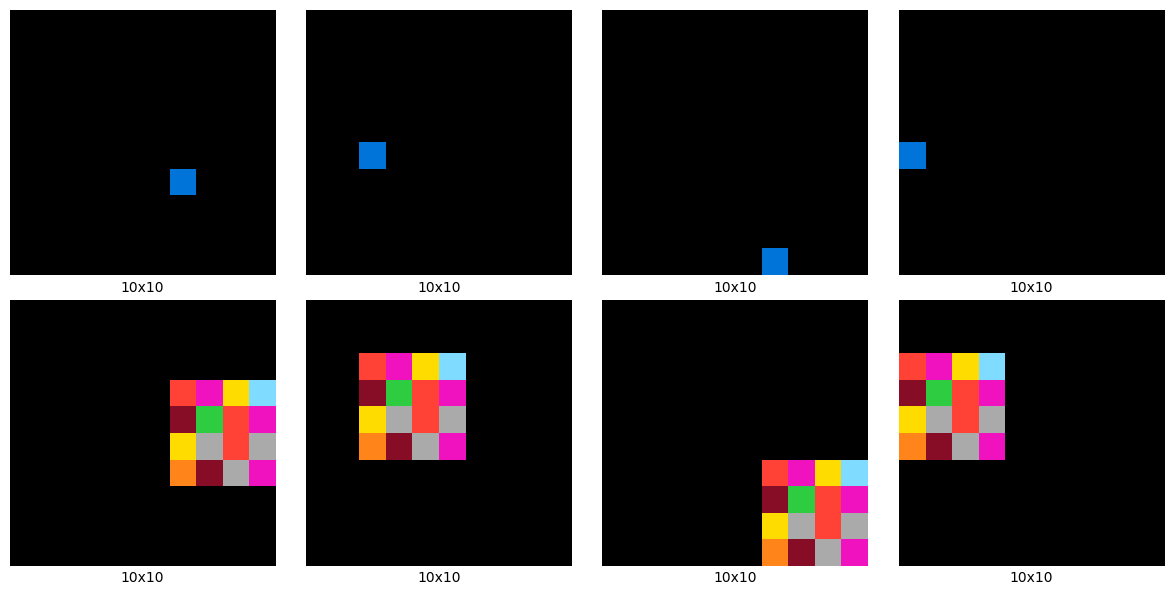

In [2]:
task_gen = PatternTaskGenerator(num_pairs=4, seed=0)
task, _ = next(iter(task_gen))
plot_task(task)

# Pattern 2D Visualization

In [ ]:
import os

import numpy as np
import jax.numpy as jnp
import jax
from scipy.stats import norm
import wandb
import omegaconf
import optax
import hydra
from flax.training.train_state import TrainState
from flax.serialization import from_bytes
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

from src.models.lpn import LPN
from src.models.transformer import EncoderTransformer, DecoderTransformer
from src.visualization import arc_cmap, arc_norm
from src.datasets.task_gen.task_generator import PatternTaskGenerator

### Load a checkpoint

In [ ]:
artifact_path = "TheThinker/ARC/quiet-thunder-789--checkpoint:v0"

run = wandb.init()
artifact = run.use_artifact(artifact_path, type='model')
run.finish()
cfg = omegaconf.OmegaConf.create(artifact.metadata)
artifact_dir = artifact.download()
omegaconf.OmegaConf.save(config=cfg, f=os.path.join(artifact_dir, "config.yaml"))

encoder = EncoderTransformer(hydra.utils.instantiate(cfg.encoder_transformer))
decoder = DecoderTransformer(hydra.utils.instantiate(cfg.decoder_transformer))
lpn = LPN(encoder=encoder, decoder=decoder)

key = jax.random.PRNGKey(0)
grids = jax.random.randint(
    key, (1, 3, decoder.config.max_rows, decoder.config.max_cols, 2), minval=0, maxval=decoder.config.vocab_size,
)
shapes = jax.random.randint(
    key, (1, 3, 2, 2), minval=1, maxval=min(decoder.config.max_rows, decoder.config.max_cols) + 1,
)
variables = lpn.init(key, grids, shapes, dropout_eval=False, prior_kl_coeff=0.0, pairwise_kl_coeff=0.0, mode="mean")

learning_rate, linear_warmup_steps = 0, 0
linear_warmup_scheduler = optax.warmup_exponential_decay_schedule(
    init_value=learning_rate / (linear_warmup_steps + 1),
    peak_value=learning_rate,
    warmup_steps=linear_warmup_steps,
    transition_steps=1,
    end_value=learning_rate,
    decay_rate=1.0,
)
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adamw(linear_warmup_scheduler))
optimizer = optax.MultiSteps(optimizer, every_k_schedule=1)
train_state = TrainState.create(apply_fn=lpn.apply, tx=optimizer, params=variables["params"])

with open(os.path.join(artifact_dir, "state.msgpack"), "rb") as data_file:
    byte_data = data_file.read()
loaded_state = from_bytes(train_state, byte_data)

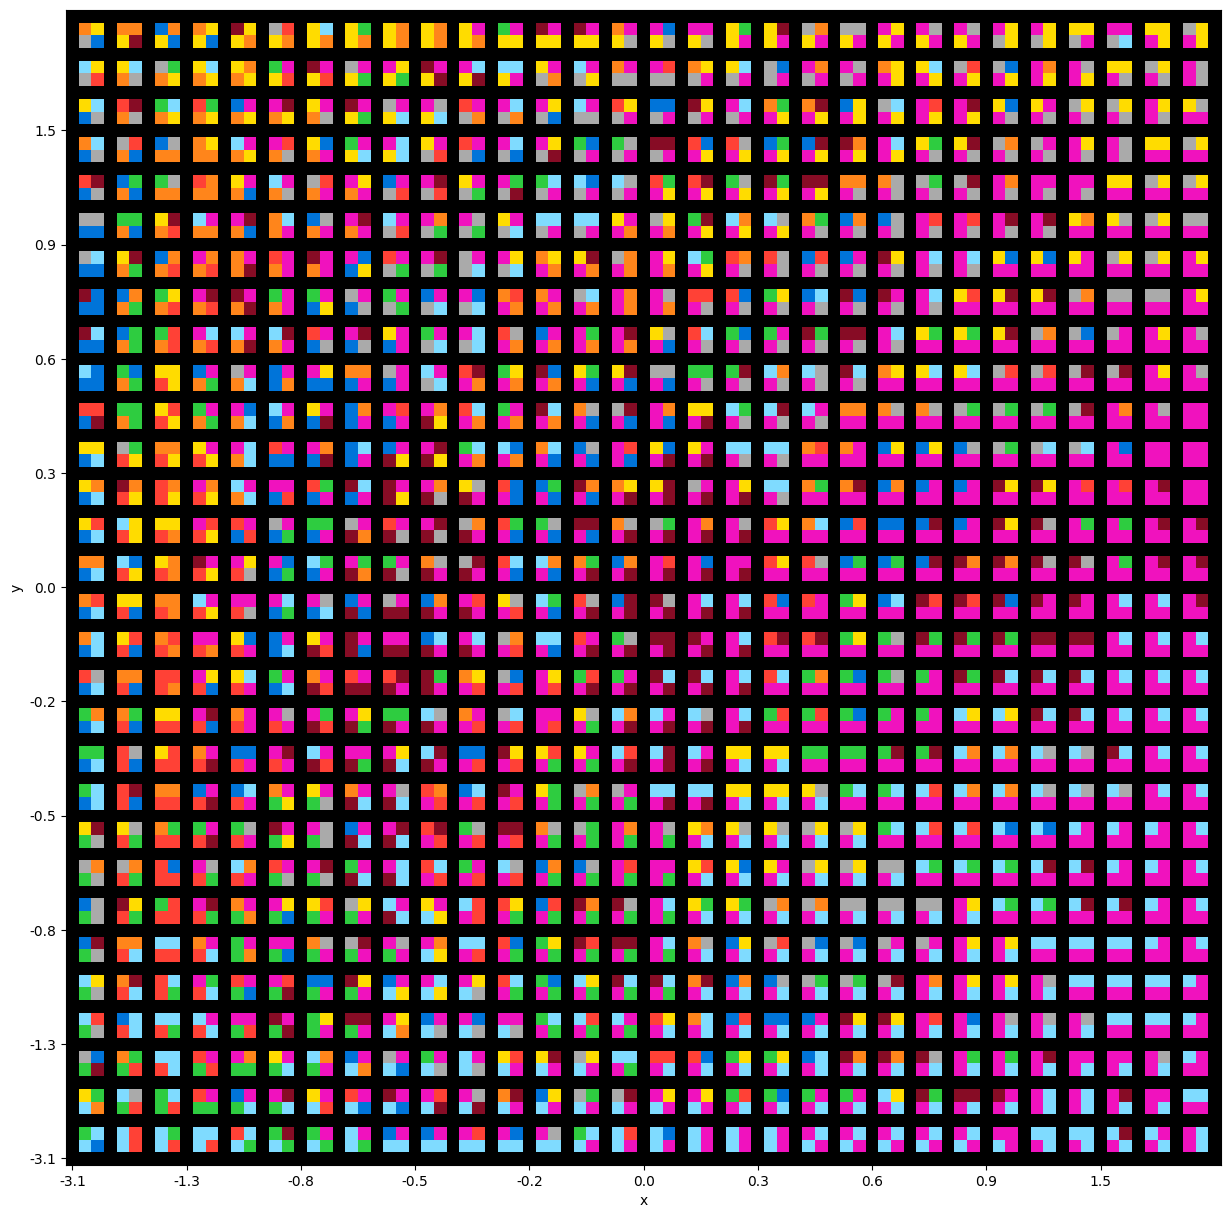

In [ ]:
num_patterns = 30
pattern_size = 2

figure = np.zeros((pattern_size * num_patterns + num_patterns + 1, pattern_size * num_patterns + num_patterns + 1))
grid_x = norm.ppf(np.linspace(0.001, 0.999, num_patterns)).astype(np.float32)
grid_y = norm.ppf(np.linspace(0.001, 0.999, num_patterns)).astype(np.float32)

generate_output_from_context = jax.jit(
    lambda context: lpn.apply(
        {"params": loaded_state.params},
        context=context,
        input=jnp.zeros((1, 4, 4), int).at[0, 0, 0].set(1),
        input_grid_shape=jnp.array([[4, 4]], int),
        dropout_eval=True,
        method=lpn._generate_output_from_context,
    )
)
for col, xi in enumerate(grid_x):
    for row, yj in enumerate(grid_y):
        output_grids, _ = generate_output_from_context(context=jnp.array([[xi, yj]]))
        pattern = output_grids[0, :2, :2]
        figure[
            row * (pattern_size + 1) + 1: row * (pattern_size + 1) + pattern_size + 1,
            col * (pattern_size + 1) + 1: col * (pattern_size + 1) + pattern_size + 1,
        ] = pattern

plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap=arc_cmap, norm=arc_norm, origin="lower")
plt.xticks(np.arange(0, pattern_size * num_patterns + num_patterns, 3*(pattern_size + 1)), grid_x.round(1)[::3])
plt.xlabel("x")
plt.yticks(np.arange(0, pattern_size * num_patterns + num_patterns, 3*(pattern_size + 1)), grid_y.round(1)[::3])
plt.ylabel("y")
plt.savefig("figures/pattern_space.pdf", bbox_inches="tight")
plt.show()

In [ ]:
encoder_call = jax.jit(
    lambda pairs, grid_shapes: lpn.encoder.apply(
        {"params": loaded_state.params["encoder"]},
        pairs=pairs,
        grid_shapes=grid_shapes,
        dropout_eval=True,
        method=lpn.encoder.__call__,
    )
)
generate_output_from_context = jax.jit(
    lambda context, input, input_grid_shape: lpn.apply(
        {"params": loaded_state.params},
        context=context,
        input=input,
        input_grid_shape=input_grid_shape,
        dropout_eval=True,
        method=lpn._generate_output_from_context,
    )
)

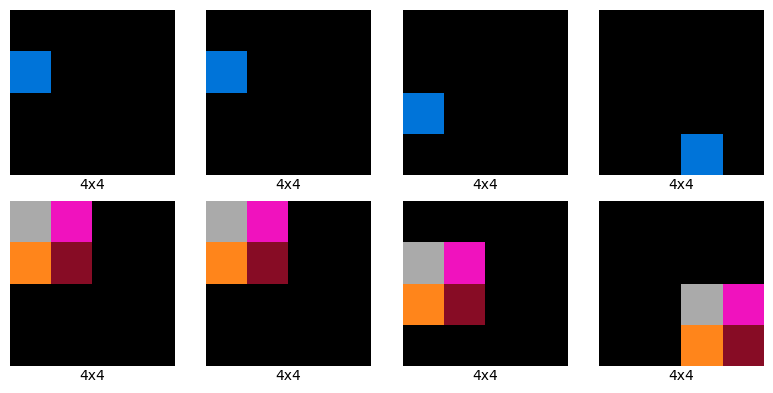

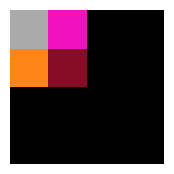

In [7]:
task_gen = PatternTaskGenerator(num_pairs=4, pattern_size=2, num_rows=4, num_cols=4, seed=0)
task, _ = next(iter(task_gen))
plot_task(task, figsize_factor=2)

inputs = jnp.stack([pair["input"] for pair in task])
outputs = jnp.stack([pair["output"] for pair in task])
pairs = jnp.stack([inputs, outputs], axis=-1)
grid_shapes = jnp.array(4*[[[4, 4], [4, 4]]], int)
latents_mu, latents_logvar = encoder_call(pairs=pairs, grid_shapes=grid_shapes)
latents = latents_mu
context = latents[1:].mean(axis=0)
output_grids, _ = generate_output_from_context(
    context=context[None], input=inputs[0][None], input_grid_shape=grid_shapes[0, :, 0][None]
)
plt.figure(figsize=(2, 2))
plt.imshow(output_grids[0], cmap=arc_cmap, norm=arc_norm, origin="lower")
plt.axis("off")
plt.show()

In [ ]:
@jax.jit
def log_prob_other_pairs(context):
    input_seq, output_seq = lpn._flatten_input_output_for_decoding(pairs[1:], grid_shapes[1:])
    row_logits, col_logits, grid_logits = lpn.decoder.apply(
        {"params": loaded_state.params["decoder"]},
        input_seq=input_seq,
        output_seq=output_seq,
        context=context[..., None, :].repeat(output_seq.shape[-2], axis=-2),
        dropout_eval=True,
    )
    log_probs = lpn._compute_log_probs(row_logits, col_logits, grid_logits, output_seq)
    return log_probs


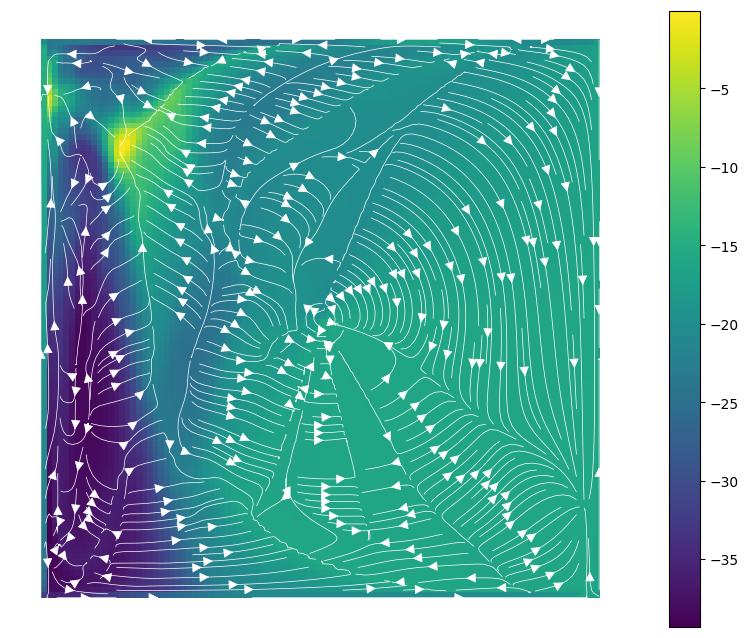

In [10]:
resolution_x, resolution_y = 100, 100
eps = 1e-6

image = np.empty((resolution_y, resolution_x), float)
grad_x = np.empty((resolution_y, resolution_x), float)
grad_y = np.empty((resolution_y, resolution_x), float)

# Create uniformly spaced grid for plotting
uniform_x = np.linspace(eps, 1-eps, resolution_x)
uniform_y = np.linspace(eps, 1-eps, resolution_y)
X, Y = np.meshgrid(uniform_x, uniform_y)

# Create transformed grid for function evaluation
grid_x = norm.ppf(uniform_x).astype(np.float32)
grid_y = norm.ppf(uniform_y).astype(np.float32)

for col, xi in enumerate(grid_x):
    for row, yj in enumerate(grid_y):
        log_prob, gradient = jax.value_and_grad(log_prob_other_pairs)(jnp.array([xi, yj]))
        image[row, col] = log_prob
        grad_x[row, col], grad_y[row, col] = gradient

# Transform gradients back to uniform space using the chain rule
pdf_x = norm.pdf(grid_x)
pdf_y = norm.pdf(grid_y)
XX, YY = np.meshgrid(pdf_x, pdf_y)
grad_x_uniform = grad_x * XX
grad_y_uniform = grad_y * YY

plt.figure(figsize=(10, 10))
plt.imshow(image, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
plt.colorbar(shrink=0.8)
plt.streamplot(X, Y, grad_x_uniform, grad_y_uniform, color='white', density=2.5, linewidth=0.5, arrowsize=1.5)
plt.axis("off")
plt.savefig("figures/log_prob_gradient_field.pdf", bbox_inches="tight")
plt.show()

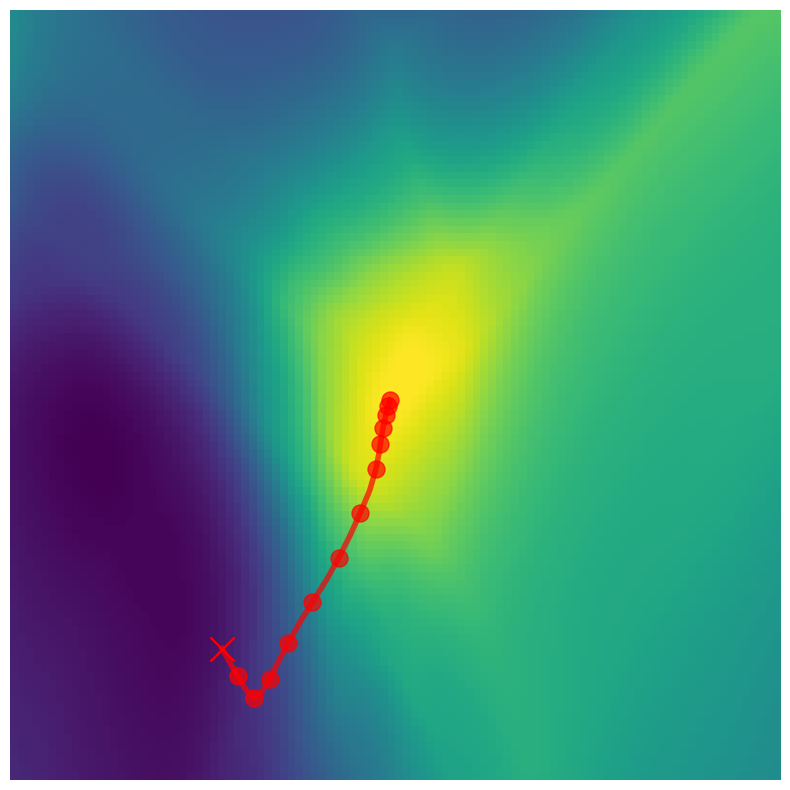

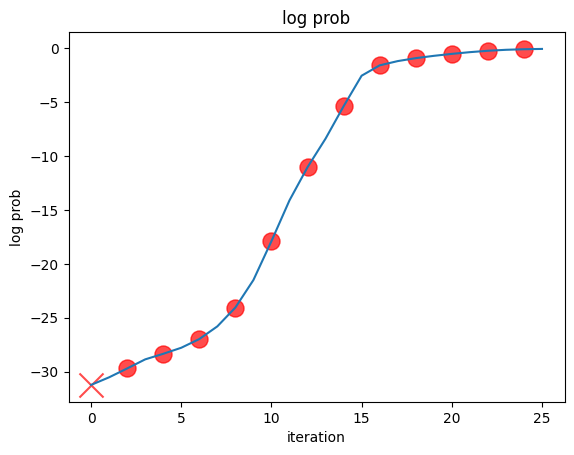

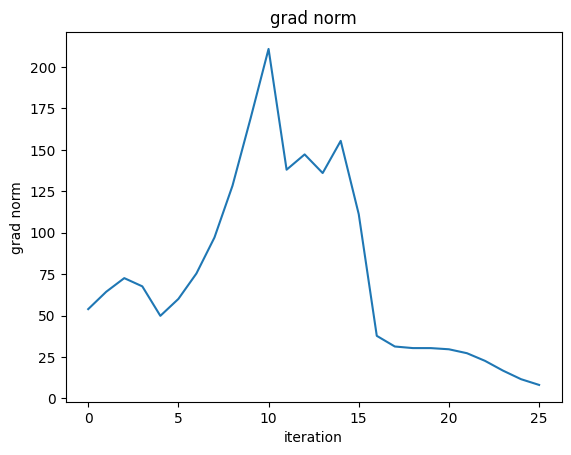

In [101]:
resolution = 100
eps = 1e-6

# Define the zoom window in CDF space
center_x, center_y = norm.cdf(context)
window_size = 0.18
x_min = max(eps, center_x - window_size / 2)
x_max = x_min + window_size
y_min = max(eps, center_y - window_size / 2)
y_max = y_min + window_size

# Create grid and compute image
image = np.empty((resolution, resolution), float)
grid_x = norm.ppf(np.linspace(x_min, x_max, resolution)).astype(np.float32)
grid_y = norm.ppf(np.linspace(y_min, y_max, resolution)).astype(np.float32)

for col, xi in enumerate(grid_x):
    for row, yj in enumerate(grid_y):
        image[row, col] = log_prob_other_pairs(context=jnp.array([xi, yj]))

# Gradient ascent
lr = 0.01
optimizer = optax.adam(learning_rate=lr, b1=0.5)
start_context = context + jnp.array([-0.2, -0.2])
current_context = start_context
opt_state = optimizer.init(current_context)
contexts, log_probs, grad_norms = [current_context], [], []
for _ in range(26):
    log_prob, grad = jax.value_and_grad(log_prob_other_pairs)(current_context)
    updates, opt_state = optimizer.update(-grad, opt_state, current_context)
    current_context = optax.apply_updates(current_context, updates)
    contexts.append(current_context)
    log_probs.append(log_prob)
    grad_norms.append(jnp.linalg.norm(grad))
trajectory_points = norm.cdf(np.stack(contexts))

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="viridis", origin="lower", extent=[x_min, x_max, y_min, y_max])
# plt.colorbar(shrink=0.8)
plt.scatter(*norm.cdf(start_context), c='red', marker='x', s=300)
plt.plot(trajectory_points[:, 0], trajectory_points[:, 1], 'r-', linewidth=4, alpha=0.7)
plt.scatter(trajectory_points[:, 0][2::2], trajectory_points[:, 1][2::2], c='red', s=150, alpha=0.7)
plt.axis("off")
plt.savefig("figures/gradient_ascent_trajectory.pdf")
plt.show()

plt.figure()
plt.plot(log_probs)
plt.scatter(0, log_probs[0], c='red', marker='x', s=300, alpha=0.7)
plt.scatter(range(2, len(log_probs), 2), log_probs[2::2], c='red', s=150, alpha=0.7)
plt.xlabel("iteration")
plt.ylabel("log prob")
plt.title("log prob")
plt.savefig("figures/gradient_ascent_trajectory_log_prob.pdf")
plt.show()

plt.figure()
plt.plot(grad_norms)
plt.xlabel("iteration")
plt.ylabel("grad norm")
plt.title("grad norm")
plt.show()

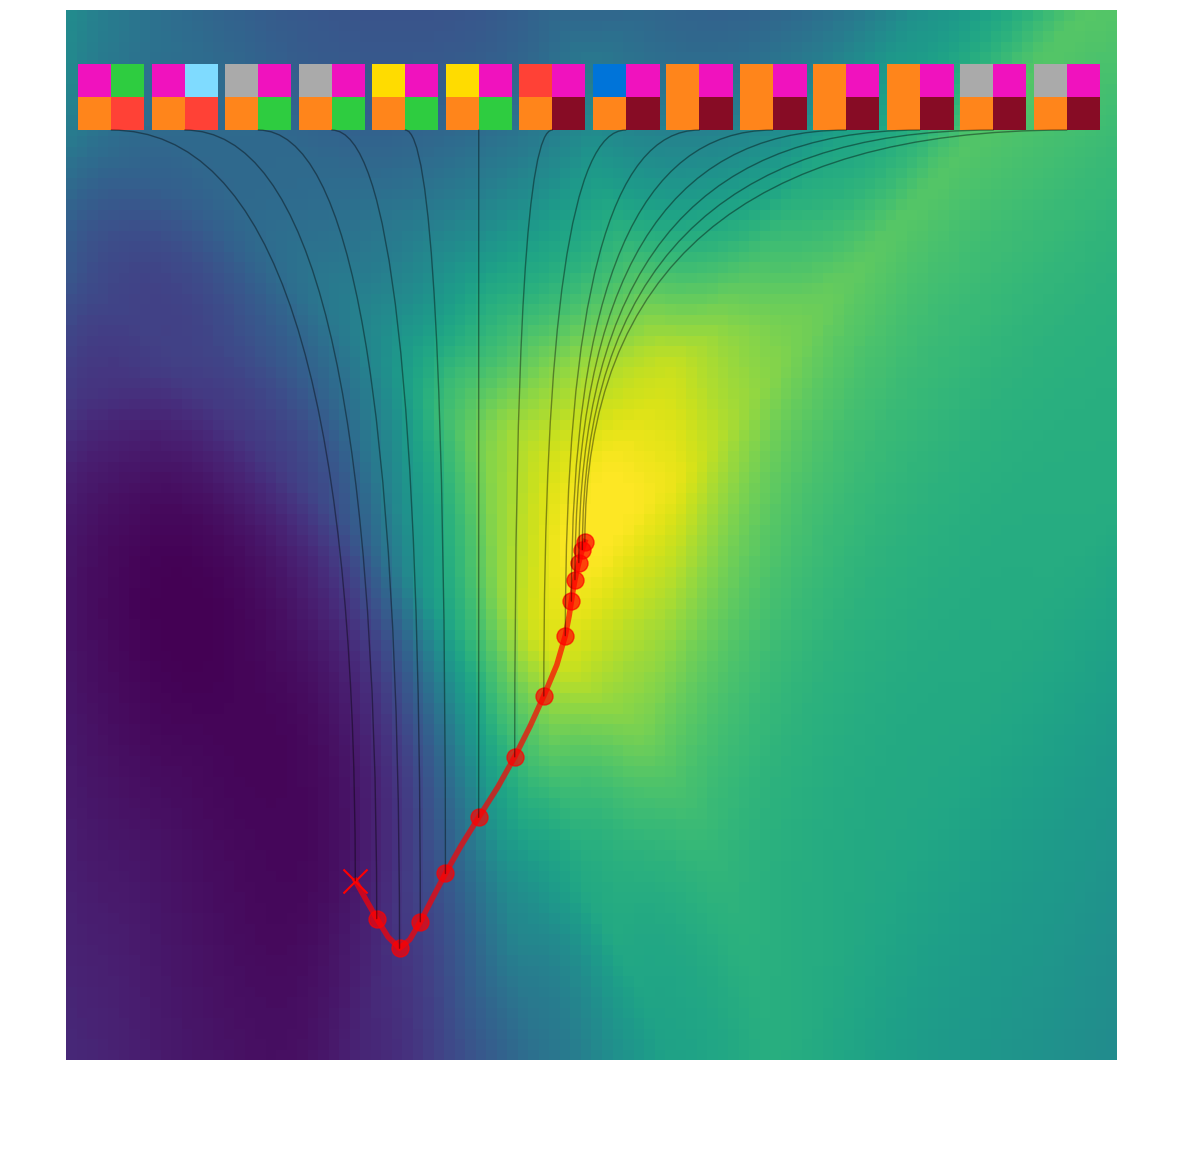

In [102]:
# Create main figure
fig = plt.figure(figsize=(15, 15))

# Create two subfigures - one for trajectory, one for small images
gs = plt.GridSpec(2, 1, height_ratios=[10, 1], hspace=0.0)

# Main trajectory plot
ax_main = fig.add_subplot(gs[0])
ax_main.imshow(image, cmap="viridis", origin="lower", extent=[x_min, x_max, y_min, y_max])
ax_main.scatter(*norm.cdf(start_context), c='red', marker='x', s=300)
ax_main.plot(trajectory_points[:, 0], trajectory_points[:, 1], 'r-', linewidth=4, alpha=0.7)
selected_points = trajectory_points[::2]  # Every other point
ax_main.scatter(selected_points[1:, 0], selected_points[1:, 1], c='red', s=150, alpha=0.7)
ax_main.axis("off")

# Create subplot for small images
ax_small_container = fig.add_subplot(gs[1])
ax_small_container.axis('off')

# Calculate positions for small images
n_images = len(selected_points)
width_ratio = 0.044  # Width of each small image relative to figure width
spacing_ratio = 0.005  # Spacing between images
total_width = n_images * width_ratio + (n_images - 1) * spacing_ratio
start_x = (1 - total_width) / 2 + width_ratio / 4

small_axes = []
for i in range(n_images):
    # Calculate position for each small image
    left = start_x + i * (width_ratio + spacing_ratio)
    bottom = 0.8
    width = width_ratio
    height = width * 1.0  # Make them square
    
    # Create and position small axis
    ax_small = fig.add_axes([left, bottom, width, height])
    
    # Generate and plot small image
    output_grids, _ = generate_output_from_context(
        context=contexts[2*i][None], 
        input=inputs[0][None], 
        input_grid_shape=grid_shapes[0, :, 0][None]
    )
    ax_small.imshow(output_grids[0][2:, :2], cmap=arc_cmap, norm=arc_norm, origin="lower")
    ax_small.axis("off")
    small_axes.append(ax_small)
    
    # Add connecting arrow
    point = selected_points[i]
    con = ConnectionPatch(
        xyA=(point[0], point[1]), coordsA=ax_main.transData,
        xyB=(left + width/2, bottom), coordsB=fig.transFigure,
        connectionstyle="angle3,angleA=90,angleB=0",
        arrowstyle="-", alpha=0.4,
        figure=fig
    )
    fig.add_artist(con)
    


# Save and show the figure
plt.savefig("figures/gradient_ascent_trajectory_with_outputs.pdf", bbox_inches='tight')
plt.show()

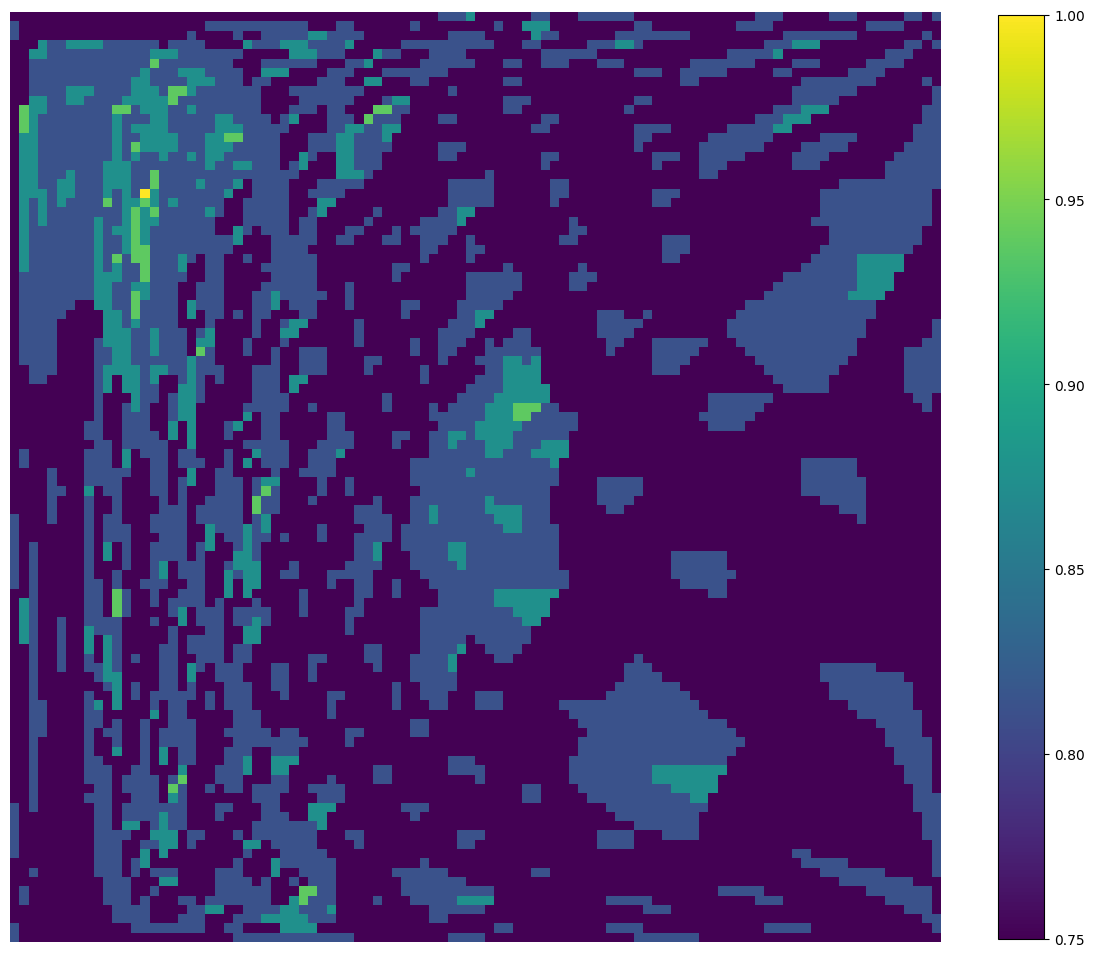

In [ ]:
num_patterns = 100

figure = np.zeros((num_patterns, num_patterns))
grid_x = norm.ppf(np.linspace(0.0001, 0.9999, num_patterns)).astype(np.float32)
grid_y = norm.ppf(np.linspace(0.0001, 0.9999, num_patterns)).astype(np.float32)

generate_output_from_context = jax.jit(
    lambda context: lpn.apply(
        {"params": loaded_state.params},
        context=context,
        input=inputs[0][None],
        input_grid_shape=jnp.array([[4, 4]], int),
        dropout_eval=True,
        method=lpn._generate_output_from_context,
    )
)
for col, xi in enumerate(grid_x):
    for row, yj in enumerate(grid_y):
        output_grids, _ = generate_output_from_context(context=jnp.array([[xi, yj]]))
        figure[row, col] = np.mean(output_grids[0] == outputs[0])

plt.figure(figsize=(15, 15))
plt.imshow(figure, origin="lower")
plt.colorbar(shrink=0.8)
plt.axis("off")
plt.show()

In [12]:
# Make a GIF

import io

from PIL import Image

frames = []
for c in contexts:
    plt.figure(figsize=(2, 2))
    output_grids, _ = generate_output_from_context(
        context=c[None], input=inputs[0][None], input_grid_shape=grid_shapes[0, :, 0][None]
    )
    plt.imshow(output_grids[0], cmap=arc_cmap, norm=arc_norm, origin="lower")
    plt.axis("off")
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close()
    buf.seek(0)
    frames.append(Image.open(buf).copy())
    
frames[0].save('figures/trajectory.gif', save_all=True, append_images=frames[1:], duration=200, loop=0)

# Overfit Exp

In [ ]:
from tqdm.auto import tqdm
import wandb

wandb.login()
runs = wandb.Api().runs(f"TheThinker/ARC")

results = {}

for run in tqdm(filter(lambda run: "EXP arc_overfit" in run.name, runs), total=5):
    task = run.name.split(" ")[-1]
    results[task] = {"total_loss": [], "_step": []}
    for row in run.scan_history(keys=["total_loss", "_step"]):
        if row.get("total_loss") is not None:
            results[task]["total_loss"].append(row["total_loss"])
            results[task]["_step"].append(row["_step"])

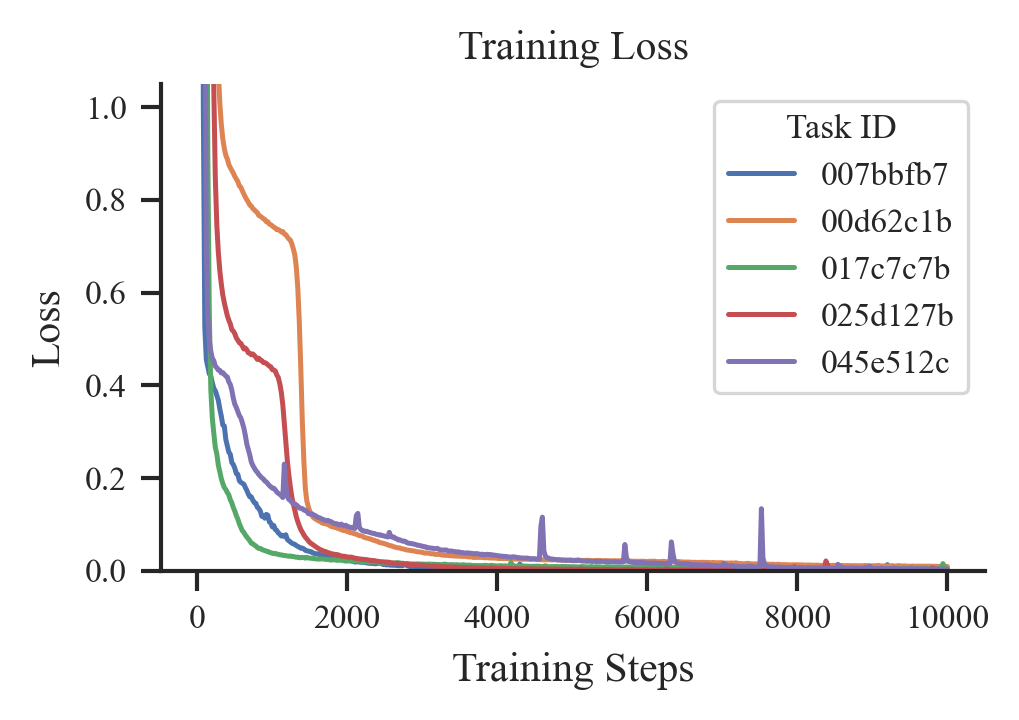

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")  # Clean style with axis ticks
sns.set_context("paper", font_scale=1.5)  # Adjust font_scale as needed
# Option 1: colorblind friendly
# sns.set_palette("colorblind")
# Option 2: deep colors that print well
sns.set_palette("deep")
plt.rcParams.update({
    'font.family': 'serif',  # Use serif font
    'font.serif': ['Times New Roman'],  # Specifically Times New Roman
    'font.size': 10,  # Base font size
    'axes.labelsize': 10,  # Label size
    'axes.titlesize': 10,  # Title size
    'xtick.labelsize': 8,  # Tick label size
    'ytick.labelsize': 8,
    'legend.fontsize': 8,  # Legend font size
    'axes.spines.top': False,  # Remove top spine
    'axes.spines.right': False,  # Remove right spine
    'figure.dpi': 300,  # High DPI for quality
    'savefig.dpi': 300,  # High DPI for saving
    'figure.figsize': (3.5, 2.5),  # Common NeurIPS figure size (in inches)
    'axes.grid': False,  # Usually no grid for papers
    'legend.title_fontsize': 'small',  # Small title in legend
})

plt.figure()
for task_id, data in results.items():
    plt.plot(data["_step"], data["total_loss"], label=task_id)
plt.legend(title="Task ID")
plt.title('Training Loss')
plt.ylim(0.0, 1.05)
plt.xlabel('Training Steps')
plt.ylabel('Loss')

sns.despine()  # Remove top and right spines
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.savefig('figures/arc_overfit_loss.pdf', bbox_inches='tight', transparent=True)

# Pattern exp

In [ ]:
import copy

from tqdm.auto import tqdm
import wandb

wandb.login()
runs = wandb.Api().runs(f"TheThinker/ARC")

accuracy = {"mean": [], "ga_1": [], "ga_5": [], "ga_20": [], "ga_100": [], "rs_25": [], "rs_250": [], "ga_100_*": [], "rs_250_*": []}
results = {
    "mean": copy.deepcopy(accuracy),
    "rs_5": copy.deepcopy(accuracy),
    "rs_25": copy.deepcopy(accuracy),
    "ga_5": copy.deepcopy(accuracy),
    "ga_5_g": copy.deepcopy(accuracy),
    "ga_1": copy.deepcopy(accuracy),
    "ga_1_ne": copy.deepcopy(accuracy),
    "ga_1_g": copy.deepcopy(accuracy),
    "ga_1_g_ne": copy.deepcopy(accuracy),
}

for run in tqdm(filter(lambda run: "EXP pattern_4" in run.name, runs), total=27):
    for key in results:
        if run.name.endswith(key):
            summary = run.summary
            for metric in summary.keys():
                for inference in results[key]:
                    if metric.endswith(f"{inference}/accuracy"):
                        results[key][inference].append(summary[metric])

In [58]:
import numpy as np

results_mean = {key: {inference: round(100*np.mean(results[key][inference]).item(), 1) for inference in results[key]} for key in results}
results_std = {key: {inference: round(100*np.std(results[key][inference]).item(), 1) for inference in results[key]} for key in results}
results_mean

{'mean': {'mean': 3.2,
  'ga_1': 3.6,
  'ga_5': 18.8,
  'ga_20': 52.5,
  'ga_100': 67.5,
  'rs_25': 3.2,
  'rs_250': 3.2,
  'ga_100_*': 32.5,
  'rs_250_*': 0.0},
 'rs_5': {'mean': 6.1,
  'ga_1': 8.2,
  'ga_5': 27.7,
  'ga_20': 56.3,
  'ga_100': 72.2,
  'rs_25': 6.1,
  'rs_250': 6.1,
  'ga_100_*': 43.7,
  'rs_250_*': 0.0},
 'rs_25': {'mean': 10.8,
  'ga_1': 13.3,
  'ga_5': 39.9,
  'ga_20': 72.3,
  'ga_100': 87.9,
  'rs_25': 10.8,
  'rs_250': 10.8,
  'ga_100_*': 60.6,
  'rs_250_*': 0.0},
 'ga_5': {'mean': 0.0,
  'ga_1': 0.4,
  'ga_5': 31.9,
  'ga_20': 88.5,
  'ga_100': 98.1,
  'rs_25': 0.1,
  'rs_250': 0.5,
  'ga_100_*': 67.6,
  'rs_250_*': 0.0},
 'ga_5_g': {'mean': 0.0,
  'ga_1': 0.0,
  'ga_5': 9.9,
  'ga_20': 87.1,
  'ga_100': 95.1,
  'rs_25': 0.0,
  'rs_250': 0.0,
  'ga_100_*': 76.6,
  'rs_250_*': 0.0},
 'ga_1': {'mean': 8.6,
  'ga_1': 44.6,
  'ga_5': 85.4,
  'ga_20': 98.4,
  'ga_100': 99.5,
  'rs_25': 8.7,
  'rs_250': 10.2,
  'ga_100_*': 69.9,
  'rs_250_*': 0.0},
 'ga_1_ne': {'mean':

Prompt used with Claude 3.5 Sonnet

I have the following latex table that I want to populate>

```
    \begin{tabular}{|l||c|c|c|c|c|c|c||c|c|}
        \hline
        & \multicolumn{9}{c|}{Inference} \\
        \cline{2-10}
        Training & Mean & GA 1 & GA 5 & GA 20 & GA 100 & RS 25 & RS 250 & GA 100$^\dagger$ & RS 250$^\dagger$ \\
        \hline
        Mean & 6.6 & 7.5 & 38.3 & 86.3 & 91.3 & 6.6 & 6.6 & 51.2 & 0.0 \\
        GA 1 & & & & & & & & & \\
        \underline{GA 1} & & & & & & & & & \\
        GA 1$^\dagger$ & & & & & & & & & \\
        \underline{GA 1}$^\dagger$ & & & & & & & & & \\
        GA 5 & & & & & & & & & \\
        \underline{GA 5} & & & & & & & & & \\
        RS 5 & & & & & & & & & \\
        RS 25 & & & & & & & & & \\
        \hline
    \end{tabular}

```

I have the values for each cell in two dictionaries: one that contains the mean values and the other the standard deviations. I want to display them on the table using the following format, e.g. `3.1 (0.5)` where the result would be 3.1 +/- 0.1
Each dictionary has the following structure: `{training_mode_1: {inference_mode_1: x_1, inference_mode_2: y_1, ...}, training_mode_2: {inference_mode_1: x_2, inference_mode_2: y_2, ...}, ...}`.
Below are the two dictionaries:

```
mean_dic = {'mean': {'mean': 3.2,
  'ga_1': 3.6,
  'ga_5': 18.8,
  'ga_20': 52.5,
  'ga_100': 67.5,
  'rs_25': 3.2,
  'rs_250': 3.2,
  'ga_100_*': 32.5,
  'rs_250_*': 0.0},
 'rs_5': {'mean': 6.1,
  'ga_1': 8.2,
  'ga_5': 27.7,
  'ga_20': 56.3,
  'ga_100': 72.2,
  'rs_25': 6.1,
  'rs_250': 6.1,
  'ga_100_*': 43.7,
  'rs_250_*': 0.0},
 'rs_25': {'mean': 10.8,
  'ga_1': 13.3,
  'ga_5': 39.9,
  'ga_20': 72.3,
  'ga_100': 87.9,
  'rs_25': 10.8,
  'rs_250': 10.8,
  'ga_100_*': 60.6,
  'rs_250_*': 0.0},
 'ga_5': {'mean': 0.0,
  'ga_1': 0.4,
  'ga_5': 31.9,
  'ga_20': 88.5,
  'ga_100': 98.1,
  'rs_25': 0.1,
  'rs_250': 0.5,
  'ga_100_*': 67.6,
  'rs_250_*': 0.0},
 'ga_5_g': {'mean': 0.0,
  'ga_1': 0.0,
  'ga_5': 9.9,
  'ga_20': 87.1,
  'ga_100': 95.1,
  'rs_25': 0.0,
  'rs_250': 0.0,
  'ga_100_*': 76.6,
  'rs_250_*': 0.0},
 'ga_1': {'mean': 8.6,
  'ga_1': 44.6,
  'ga_5': 85.4,
  'ga_20': 98.4,
  'ga_100': 99.5,
  'rs_25': 8.7,
  'rs_250': 10.2,
  'ga_100_*': 69.9,
  'rs_250_*': 0.0},
 'ga_1_ne': {'mean': 0.0,
  'ga_1': 0.0,
  'ga_5': 0.0,
  'ga_20': 0.0,
  'ga_100': 0.0,
  'rs_25': 0.0,
  'rs_250': 0.0,
  'ga_100_*': 0.0,
  'rs_250_*': 0.0},
 'ga_1_g': {'mean': 0.6,
  'ga_1': 13.7,
  'ga_5': 60.2,
  'ga_20': 88.9,
  'ga_100': 94.1,
  'rs_25': 0.7,
  'rs_250': 0.7,
  'ga_100_*': 65.4,
  'rs_250_*': 0.0},
 'ga_1_g_ne': {'mean': 0.0,
  'ga_1': 0.0,
  'ga_5': 0.0,
  'ga_20': 0.0,
  'ga_100': 0.0,
  'rs_25': 0.0,
  'rs_250': 0.0,
  'ga_100_*': 0.0,
  'rs_250_*': 0.0}}

std_dic = {'mean': {'mean': 2.7,
  'ga_1': 3.0,
  'ga_5': 14.4,
  'ga_20': 25.0,
  'ga_100': 20.0,
  'rs_25': 2.7,
  'rs_250': 2.7,
  'ga_100_*': 13.3,
  'rs_250_*': 0.0},
 'rs_5': {'mean': 4.4,
  'ga_1': 6.5,
  'ga_5': 21.6,
  'ga_20': 27.5,
  'ga_100': 21.2,
  'rs_25': 4.4,
  'rs_250': 4.4,
  'ga_100_*': 20.9,
  'rs_250_*': 0.0},
 'rs_25': {'mean': 8.0,
  'ga_1': 10.1,
  'ga_5': 21.4,
  'ga_20': 18.5,
  'ga_100': 9.2,
  'rs_25': 8.0,
  'rs_250': 8.0,
  'ga_100_*': 21.3,
  'rs_250_*': 0.0},
 'ga_5': {'mean': 0.0,
  'ga_1': 0.3,
  'ga_5': 11.2,
  'ga_20': 11.9,
  'ga_100': 2.1,
  'rs_25': 0.1,
  'rs_250': 0.4,
  'ga_100_*': 18.8,
  'rs_250_*': 0.0},
 'ga_5_g': {'mean': 0.0,
  'ga_1': 0.0,
  'ga_5': 2.9,
  'ga_20': 6.0,
  'ga_100': 3.3,
  'rs_25': 0.0,
  'rs_250': 0.0,
  'ga_100_*': 9.7,
  'rs_250_*': 0.0},
 'ga_1': {'mean': 4.4,
  'ga_1': 10.9,
  'ga_5': 7.6,
  'ga_20': 1.4,
  'ga_100': 0.5,
  'rs_25': 4.5,
  'rs_250': 5.3,
  'ga_100_*': 16.7,
  'rs_250_*': 0.0},
 'ga_1_ne': {'mean': 0.0,
  'ga_1': 0.0,
  'ga_5': 0.0,
  'ga_20': 0.0,
  'ga_100': 0.0,
  'rs_25': 0.0,
  'rs_250': 0.0,
  'ga_100_*': 0.0,
  'rs_250_*': 0.0},
 'ga_1_g': {'mean': 0.1,
  'ga_1': 3.0,
  'ga_5': 7.5,
  'ga_20': 6.0,
  'ga_100': 3.8,
  'rs_25': 0.1,
  'rs_250': 0.2,
  'ga_100_*': 21.2,
  'rs_250_*': 0.0},
 'ga_1_g_ne': {'mean': 0.0,
  'ga_1': 0.0,
  'ga_5': 0.0,
  'ga_20': 0.0,
  'ga_100': 0.0,
  'rs_25': 0.0,
  'rs_250': 0.0,
  'ga_100_*': 0.0,
  'rs_250_*': 0.0}}
```

Can you populate the latex table with these?

# Pattern ODD

In [ ]:
import copy

from tqdm.auto import tqdm
import wandb

wandb.login()
runs = wandb.Api().runs(f"TheThinker/ARC")

accuracy = {"in_dist_mean": [], "in_dist_ga_10": [], "in_dist_ga_100": [], "0.75_mean": [], "0.75_ga_10": [], "0.75_ga_100": [], "1.0_mean": [], "1.0_ga_10": [], "1.0_ga_100": []}
results = {
    "mean": copy.deepcopy(accuracy),
    "ga_1": copy.deepcopy(accuracy),
    "ga_2": copy.deepcopy(accuracy),
    "ga_3": copy.deepcopy(accuracy),
    "ga_1_g": copy.deepcopy(accuracy),
}
for run in tqdm(filter(lambda run: "EXP pattern_ood" in run.name, runs), total=15):
    for key in results:
        if run.name.endswith(key):
            summary = run.summary
            for metric in summary.keys():
                for inference in results[key]:
                    if metric.endswith(f"{inference}/accuracy"):
                        if summary.get(metric) is None:
                            print(run.name, inference, metric)
                        results[key][inference].append(summary.get(metric))


In [18]:
import numpy as np

results_mean = {key: {inference: round(100*np.mean(results[key][inference]).item(), 1) for inference in results[key]} for key in results}
results_std = {key: {inference: round(100*np.std(results[key][inference]).item(), 1) for inference in results[key]} for key in results}
results_std

{'mean': {'in_dist_mean': 15.7,
  'in_dist_ga_10': 29.5,
  'in_dist_ga_100': 21.3,
  '0.75_mean': 5.6,
  '0.75_ga_10': 35.7,
  '0.75_ga_100': 38.3,
  '1.0_mean': 0.5,
  '1.0_ga_10': 14.5,
  '1.0_ga_100': 29.6},
 'ga_1': {'in_dist_mean': 7.4,
  'in_dist_ga_10': 0.6,
  'in_dist_ga_100': 0.6,
  '0.75_mean': 4.4,
  '0.75_ga_10': 4.3,
  '0.75_ga_100': 2.2,
  '1.0_mean': 0.0,
  '1.0_ga_10': 11.6,
  '1.0_ga_100': 5.3},
 'ga_2': {'in_dist_mean': 3.5,
  'in_dist_ga_10': 1.6,
  'in_dist_ga_100': 1.2,
  '0.75_mean': 2.6,
  '0.75_ga_10': 6.0,
  '0.75_ga_100': 2.1,
  '1.0_mean': 0.0,
  '1.0_ga_10': 13.0,
  '1.0_ga_100': 10.9},
 'ga_3': {'in_dist_mean': 0.7,
  'in_dist_ga_10': 6.3,
  'in_dist_ga_100': 1.9,
  '0.75_mean': 0.0,
  '0.75_ga_10': 7.8,
  '0.75_ga_100': 3.8,
  '1.0_mean': 0.0,
  '1.0_ga_10': 9.3,
  '1.0_ga_100': 14.0},
 'ga_1_g': {'in_dist_mean': 6.4,
  'in_dist_ga_10': 5.1,
  'in_dist_ga_100': 1.9,
  '0.75_mean': 1.0,
  '0.75_ga_10': 13.3,
  '0.75_ga_100': 5.5,
  '1.0_mean': 0.0,
  '1.0_g

Prompt used with Claude 3.5 Sonnet

I have the following latex table that I want to populate>

```
    \begin{tabular}{|l||c|c|c|c|c|c|c|c|c|}
        \hline
        & \multicolumn{9}{c|}{Inference} \\
        \cline{2-10}
        & \multicolumn{3}{c|}{Training Distribution} & \multicolumn{3}{c|}{Weakly OOD} & \multicolumn{3}{c|}{Strongly OOD} \\
        \cline{2-10}
        Training & Mean & GA 10 & GA 100 & Mean & GA 10 & GA 100 & Mean & GA 10 & GA 100 \\
        \hline
        Mean &  &  &  &  &  &  &  &  & \\
        GA 1 & & & & & & & & & \\
        GA 2 & & & & & & & & & \\
        GA 3 & & & & & & & & & \\
        \underline{GA 1} & & & & & & & & & \\
        \hline
    \end{tabular}
```

I have the values for each cell in two dictionaries: one that contains the mean values and the other the standard deviations. I want to display them on the table using the following format, e.g. `3.1 (0.5)` where the result would be 3.1 +/- 0.1
Each dictionary has the following structure: `{training_mode_1: {inference_mode_1: x_1, inference_mode_2: y_1, ...}, training_mode_2: {inference_mode_1: x_2, inference_mode_2: y_2, ...}, ...}`.
Below are the two dictionaries:

```
mean_dic = {'mean': {'in_dist_mean': 30.2,
  'in_dist_ga_10': 72.8,
  'in_dist_ga_100': 82.2,
  '0.75_mean': 7.6,
  '0.75_ga_10': 51.3,
  '0.75_ga_100': 62.8,
  '1.0_mean': 0.3,
  '1.0_ga_10': 18.8,
  '1.0_ga_100': 41.1},
 'ga_1': {'in_dist_mean': 26.6,
  'in_dist_ga_10': 98.0,
  'in_dist_ga_100': 99.2,
  '0.75_mean': 7.4,
  '0.75_ga_10': 93.1,
  '0.75_ga_100': 97.7,
  '1.0_mean': 0.0,
  '1.0_ga_10': 59.9,
  '1.0_ga_100': 88.0},
 'ga_2': {'in_dist_mean': 14.4,
  'in_dist_ga_10': 97.2,
  'in_dist_ga_100': 98.9,
  '0.75_mean': 3.0,
  '0.75_ga_10': 86.1,
  '0.75_ga_100': 95.9,
  '1.0_mean': 0.0,
  '1.0_ga_10': 38.5,
  '1.0_ga_100': 81.8},
 'ga_3': {'in_dist_mean': 1.0,
  'in_dist_ga_10': 85.7,
  'in_dist_ga_100': 98.3,
  '0.75_mean': 0.0,
  '0.75_ga_10': 55.0,
  '0.75_ga_100': 93.9,
  '1.0_mean': 0.0,
  '1.0_ga_10': 11.3,
  '1.0_ga_100': 72.0},
 'ga_1_g': {'in_dist_mean': 10.6,
  'in_dist_ga_10': 93.8,
  'in_dist_ga_100': 97.4,
  '0.75_mean': 1.3,
  '0.75_ga_10': 81.7,
  '0.75_ga_100': 91.5,
  '1.0_mean': 0.0,
  '1.0_ga_10': 40.9,
  '1.0_ga_100': 71.1}}

std_dic = {'mean': {'in_dist_mean': 15.7,
  'in_dist_ga_10': 29.5,
  'in_dist_ga_100': 21.3,
  '0.75_mean': 5.6,
  '0.75_ga_10': 35.7,
  '0.75_ga_100': 38.3,
  '1.0_mean': 0.5,
  '1.0_ga_10': 14.5,
  '1.0_ga_100': 29.6},
 'ga_1': {'in_dist_mean': 7.4,
  'in_dist_ga_10': 0.6,
  'in_dist_ga_100': 0.6,
  '0.75_mean': 4.4,
  '0.75_ga_10': 4.3,
  '0.75_ga_100': 2.2,
  '1.0_mean': 0.0,
  '1.0_ga_10': 11.6,
  '1.0_ga_100': 5.3},
 'ga_2': {'in_dist_mean': 3.5,
  'in_dist_ga_10': 1.6,
  'in_dist_ga_100': 1.2,
  '0.75_mean': 2.6,
  '0.75_ga_10': 6.0,
  '0.75_ga_100': 2.1,
  '1.0_mean': 0.0,
  '1.0_ga_10': 13.0,
  '1.0_ga_100': 10.9},
 'ga_3': {'in_dist_mean': 0.7,
  'in_dist_ga_10': 6.3,
  'in_dist_ga_100': 1.9,
  '0.75_mean': 0.0,
  '0.75_ga_10': 7.8,
  '0.75_ga_100': 3.8,
  '1.0_mean': 0.0,
  '1.0_ga_10': 9.3,
  '1.0_ga_100': 14.0},
 'ga_1_g': {'in_dist_mean': 6.4,
  'in_dist_ga_10': 5.1,
  'in_dist_ga_100': 1.9,
  '0.75_mean': 1.0,
  '0.75_ga_10': 13.3,
  '0.75_ga_100': 5.5,
  '1.0_mean': 0.0,
  '1.0_ga_10': 19.8,
  '1.0_ga_100': 14.3}}
```

Can you populate the latex table with these?

# ARC-AGI

In [ ]:
import wandb
from tqdm.auto import tqdm

wandb.login()

run1 = wandb.Api().run(f"TheThinker/ARC/pgbry1r7")
print(run1.name)
loss_x, loss_y, accuracy_x, accuracy_y = [], [], [], []
for row in tqdm(run1.scan_history()):
    if row["_step"] > 120_000:
        break
    if row.get("total_loss") is not None:
        loss_x.append(row["_step"])
        loss_y.append(row["total_loss"])
    if row.get("test/arc-agi_training_challenges_mean/top_2_accuracy") is not None:
        accuracy_x.append(row["_step"])
        accuracy_y.append(row["test/arc-agi_training_challenges_mean/top_2_accuracy"])

run2 = wandb.Api().run(f"TheThinker/ARC/9i9vocz5")
print(run2.name)
for row in tqdm(run2.scan_history()):
    if row["_step"] <= 120_000:
        continue
    if row["_step"] > 220_000:
        break
    if row.get("total_loss") is not None:
        loss_x.append(row["_step"])
        loss_y.append(row["total_loss"])
    if row.get("test/arc-agi_training_challenges_mean/top_2_accuracy") is not None:
        accuracy_x.append(row["_step"])
        accuracy_y.append(row["test/arc-agi_training_challenges_mean/top_2_accuracy"])

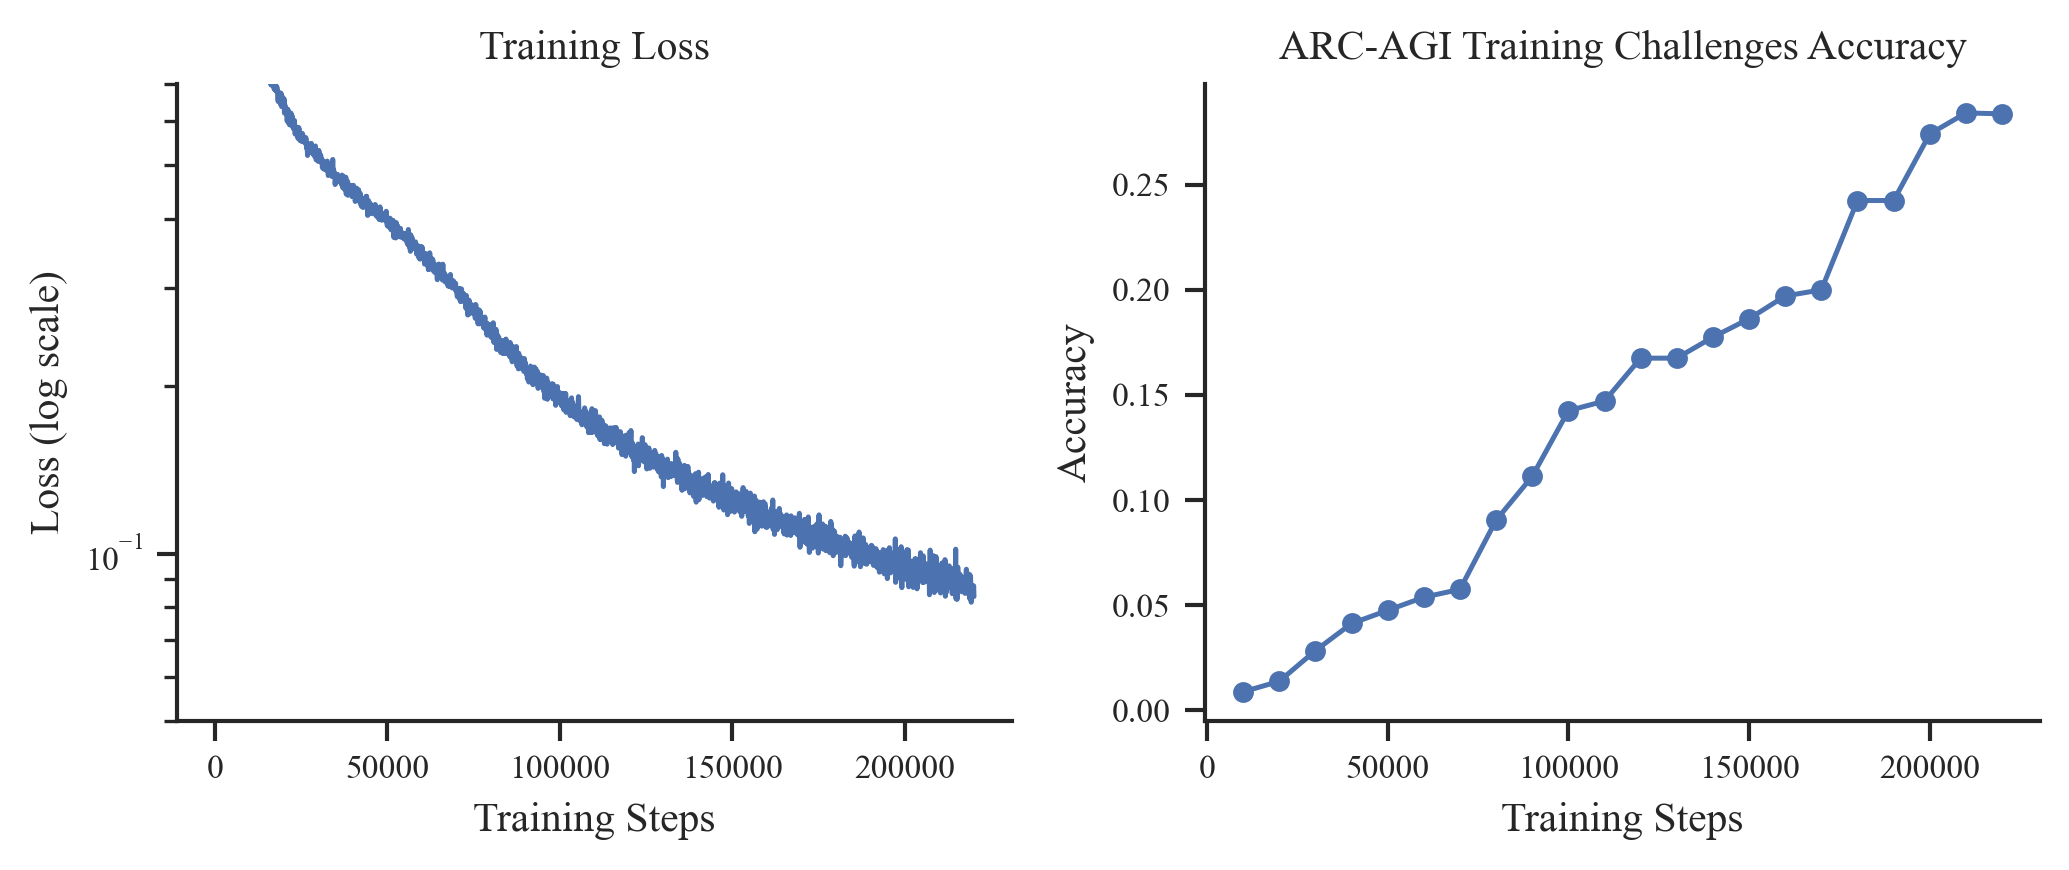

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterSciNotation
import numpy as np
import seaborn as sns

sns.set_style("ticks")  # Clean style with axis ticks
sns.set_context("paper", font_scale=1.5)  # Adjust font_scale as needed
# Option 1: colorblind friendly
# sns.set_palette("colorblind")
# Option 2: deep colors that print well
sns.set_palette("deep")
plt.rcParams.update({
    'font.family': 'serif',  # Use serif font
    'font.serif': ['Times New Roman'],  # Specifically Times New Roman
    'font.size': 10,  # Base font size
    'axes.labelsize': 10,  # Label size
    'axes.titlesize': 10,  # Title size
    'xtick.labelsize': 8,  # Tick label size
    'ytick.labelsize': 8,
    'legend.fontsize': 8,  # Legend font size
    'axes.spines.top': False,  # Remove top spine
    'axes.spines.right': False,  # Remove right spine
    'figure.dpi': 300,  # High DPI for quality
    'savefig.dpi': 300,  # High DPI for saving
    'figure.figsize': (3.5, 2.5),  # Common NeurIPS figure size (in inches)
    'axes.grid': False,  # Usually no grid for papers
})

fig, axes = plt.subplots(1, 2, figsize=(7, 3))
axes[0].plot(loss_x, loss_y)
axes[0].set_title('Training Loss')
axes[0].set_yscale('log')
axes[0].set_ylim(0.05, 0.7)
axes[0].set_xlabel('Training Steps')
axes[0].set_ylabel('Loss (log scale)')
axes[1].plot(accuracy_x, accuracy_y, 'o-', markersize=4)
axes[1].set_title('ARC-AGI Training Challenges Accuracy')
axes[1].set_xlabel('Training Steps')
axes[1].set_ylabel('Accuracy')

sns.despine()  # Remove top and right spines
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.savefig('figures/arc_agi_curves.pdf', bbox_inches='tight', transparent=True)